In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import os
from sktime.datasets import load_from_arff_to_dataframe
from pyts.utils import windowed_view
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix

# Feature extraction

In [62]:
def feature_extraction(data, apply_fft=True):

    def aux_extract(data):
        features = []
        features.append(data.mean(1))
        features.append(data.std(1))
        features.append(np.abs(data - data.mean(1)[:, np.newaxis, :]).mean(1))
        features.append(data.min(1))
        features.append(data.max(1))
        features.append(data.max(1) - data.min(1))

        features.append(np.median(data, axis=1))
        features.append(np.median(np.abs(data - np.median(data,1)[:, np.newaxis, :]),1))
        features.append(np.subtract(*np.percentile(data,[75, 25],1)))
        features.append(np.count_nonzero(data < 0, 1))
        features.append(np.count_nonzero(data >= 0, 1))
        features.append(np.count_nonzero(data > data.mean(1)[:, np.newaxis, :], 1))

        features.append(np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 1, data))
        features.append(np.nan_to_num(skew(data,axis=1)))
        features.append(np.nan_to_num(kurtosis(data, axis=1)))
        features.append(np.mean(data**2,axis=1))
        features.append(np.mean(np.sqrt(np.sum(data**2,axis=-1)),axis=1)[:, np.newaxis])
        features.append(np.sum(np.mean(np.abs(data),axis=1),axis=1)[:, np.newaxis])

        features = np.concatenate(features,axis=1)

        return features
    
    seq_len = data.shape[1]
    fft_data = np.abs(np.fft.fft(data,axis=1))[:, 1:(seq_len//2+1), :]

    result = aux_extract(data)
    if apply_fft:
        result = np.concatenate([result, aux_extract(fft_data)],axis=1)

    return result

In [63]:
def feature_extraction_window(data, window_size=10, window_step=3, apply_fft=True):

    data = np.stack(
        [
            windowed_view(data[:,:,idx], window_size, window_step)
            for idx in range(data.shape[-1])
        ],
        axis=-1
    )

    def aux_extract(data, prefix=""):
        n_samples, n_windows, _, dims = data.shape

        features = []
        feature_names = []
        features.append(data.mean(2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}mean{i}_dim{j}" for i in range(n_windows) for j in range(dims)])
    
        features.append(data.std(2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}std{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.abs(data - data.mean(2)[:, :, np.newaxis, :]).mean(2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}mae{i}_dim{j}" for i in range(n_windows) for j in range(dims)])
    
        features.append(data.min(2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}min{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(data.max(2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}max{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(data.max(2).reshape(n_samples,-1) - data.min(2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}extremadiff{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.median(data, axis=2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}median{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.median(np.abs(data - np.median(data,2)[:, :, np.newaxis, :]),2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}mad{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.subtract(*np.percentile(data,[75, 25],2)).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}iqr{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.count_nonzero(data < 0, 2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}neg{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.count_nonzero(data >= 0, 2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}pos{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.count_nonzero(data > data.mean(2)[:, :, np.newaxis, :], 2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}above_mean{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 2, data).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}peaks{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.nan_to_num(skew(data,axis=2).reshape(n_samples,-1)))
        feature_names.extend([f"{prefix}skew{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.nan_to_num(kurtosis(data, axis=2).reshape(n_samples,-1)))
        feature_names.extend([f"{prefix}krt{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.mean(data**2,axis=2).reshape(n_samples,-1))
        feature_names.extend([f"{prefix}energy{i}_dim{j}" for i in range(n_windows) for j in range(dims)])

        features.append(np.mean(np.sqrt(np.sum(data**2,axis=-1)),axis=2)[:, :, np.newaxis].reshape(n_samples,-1))
        feature_names.extend([f"{prefix}acc{i}" for i in range(n_windows)])

        features.append(np.sum(np.mean(np.abs(data),axis=2),axis=2)[:, :, np.newaxis].reshape(n_samples,-1))
        feature_names.extend([f"{prefix}sma{i}" for i in range(n_windows)])

        features = np.concatenate(features,axis=1)

        return features, feature_names
    
    seq_len = data.shape[2]
    fft_data = np.abs(np.fft.fft(data, axis=2))[:, :, 1:(seq_len//2+1), :]
    result,res_names = aux_extract(data)
    if apply_fft:
        fft_res, fft_feat = aux_extract(fft_data, "fft_")
        result = np.concatenate([result, fft_res],axis=1)
        res_names = res_names + fft_feat
    return result, res_names

# Read data + convert numpy

In [78]:
DATASET = "racketsports" # ["racketsports", "mitbih", "ptbdb"]
DATA_PATH = "data"
LABEL_COL = 187

In [79]:
def dataframe2numpy(X):
    N = len(X)
    S = len(X.iloc[0][0])
    H = len(X.columns)
    return np.stack(X.values.reshape(-1)).reshape(N,S,H)

In [80]:
if DATASET == "racketsports":

    X_train, y_train = load_from_arff_to_dataframe(
        os.path.join(DATA_PATH, "RacketSports/RacketSports_TRAIN.arff")
    )

    X_test, y_test = load_from_arff_to_dataframe(
        os.path.join(DATA_PATH, "RacketSports/RacketSports_TEST.arff")
    )

    rs_train = dataframe2numpy(X_train)
    rs_test = dataframe2numpy(X_test)

    label2id = {el:i for i, el in enumerate(list(np.unique(y_train)))}

    target_train = pd.Series(y_train).apply(lambda x:label2id[x]).values
    target_test = pd.Series(y_test).apply(lambda x:label2id[x]).values

    train_features, feature_names = feature_extraction_window(rs_train)
    test_features,_ = feature_extraction_window(rs_test)

elif DATASET == "mitbih":

    mit_bih_train = pd.read_csv(os.path.join("data","ECG","mitbih_train.csv"),header=None)
    target_train = mit_bih_train[LABEL_COL].copy().values
    mit_bih_train.drop(LABEL_COL,axis=1,inplace=True)

    mit_bih_test = pd.read_csv(os.path.join("data","ECG","mitbih_test.csv"),header=None)
    target_test = mit_bih_test[LABEL_COL].copy().values
    mit_bih_test.drop(LABEL_COL,axis=1,inplace=True)

    mitbih_train = mit_bih_train.values
    mitbih_test = mit_bih_test.values

    train_features,feature_names = feature_extraction_window(mitbih_train[:,:,np.newaxis], 20, 8)
    test_features,_ = feature_extraction_window(mitbih_test[:,:,np.newaxis], 20, 8)

elif DATASET == "ptbdb":
    
    abnormal = pd.read_csv(os.path.join("data","ECG","ptbdb_abnormal.csv"),header=None)
    normal = pd.read_csv(os.path.join("data","ECG","ptbdb_normal.csv"),header=None)

    train_abn, test_abn = train_test_split(abnormal, test_size=0.2, random_state=42)
    train_nor, test_nor = train_test_split(normal, test_size=0.2, random_state=42)

    ptbdb_train = pd.concat([train_abn, train_nor]).sample(frac=1, random_state=42).reset_index(drop=True)
    ptbdb_test = pd.concat([test_abn, test_nor]).sample(frac=1, random_state=42).reset_index(drop=True)

    target_train = ptbdb_train[LABEL_COL].copy()
    ptbdb_train.drop(LABEL_COL,axis=1,inplace=True)

    target_test = ptbdb_test[LABEL_COL].copy()
    ptbdb_test.drop(LABEL_COL,axis=1,inplace=True)

    ptbdb_train = ptbdb_train.values
    ptbdb_test = ptbdb_test.values

    train_features, feature_names = feature_extraction_window(ptbdb_train[:,:,np.newaxis],20,8)
    test_features,_ = feature_extraction_window(ptbdb_test[:,:,np.newaxis],20,8)
    


# Feature selection & standardization

In [81]:
selecter = VarianceThreshold(2.0)
scaler = StandardScaler()

In [82]:
selecter = selecter.fit(train_features)
selected_train = selecter.transform(train_features)
selected_test = selecter.transform(test_features)

In [83]:
scaler = scaler.fit(selected_train)
scaled_train = scaler.transform(selected_train)
scaled_test = scaler.transform(selected_test)

In [84]:
print(train_features.shape, scaled_train.shape)

(151, 1372) (151, 902)


In [85]:
idxs = selecter.get_support(indices=True)
selected_feats = [elem for i,elem in enumerate(feature_names) if i in idxs]
len(selected_feats)

902

# Hyperparameter search

In [12]:
MODEL_NAME = "svm" # ["svm", "rforest", "xgb"]
MODEL = None
MODEL_PARAMS = None

In [13]:
if MODEL_NAME == "svm":
    MODEL = SVC()
    MODEL_PARAMS = {
        "kernel":["linear"],
        "C":[1.0, 10.0]
    }

elif MODEL_NAME == "rforest":
    MODEL = RandomForestClassifier()
    MODEL_PARAMS = {
        "n_estimators":range(40,301,20),
        "max_depth":[3, 5, 8, 12],
        "max_samples":[0.4, 0.7, 1.0]
    }

elif MODEL_NAME == "xgb":
    MODEL = XGBClassifier()
    MODEL_PARAMS = {
        "n_estimators":range(40,101,20),
        "max_depth":[3, 5, 8],
        "learning_rate":[1e-3, 1e-2, 1e-1]
    }

else:
    print("Untested model")

In [14]:
clf = GridSearchCV(MODEL, MODEL_PARAMS,scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"], refit="accuracy", n_jobs=-1)

In [ ]:
clf = clf.fit(scaled_train, target_train)

In [16]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}

# Evaluation

In [17]:
cols = [
    "params",
    "mean_test_accuracy",
    "std_test_accuracy",
    "mean_test_precision_macro",
    "std_test_precision_macro",
    "mean_test_recall_macro",
    "std_test_recall_macro",
    "mean_test_f1_macro",
    "std_test_f1_macro"
]

grid_results = pd.DataFrame(clf.cv_results_)[cols]

In [18]:
grid_results.params = grid_results.params.apply(
    lambda x: ", ".join([f"{k}={v}" for k, v in x.items()])
)

In [19]:
grid_results.columns = list(map(lambda s:s.replace("_test",""),grid_results.columns))
grid_results = grid_results.round(3)

In [20]:
grid_results.to_excel(f"{DATASET}_{MODEL_NAME}_cv.xlsx")

In [32]:
results_df = []

for i, params in enumerate(pd.DataFrame(clf.cv_results_)["params"]):
    if MODEL_NAME == "svm":
        curr_model = SVC(**params)
    elif MODEL_NAME == "rforest":
        curr_model = RandomForestClassifier(**params)
    elif MODEL_NAME == "xgb":
        curr_model = XGBClassifier(**params)
    
    curr_model = curr_model.fit(scaled_train, target_train)

    y_true = target_test
    y_pred = curr_model.predict(scaled_test)


    param_str = ", ".join([f"{k}={v}" for k,v in params.items()])
    row = [param_str]
    
    accuracy = accuracy_score(y_true, y_pred)
    row.append(accuracy)
    res = list(map(np.mean, precision_recall_fscore_support(y_true, y_pred, zero_division=0)))
    res2 = list(map(np.std, precision_recall_fscore_support(y_true, y_pred, zero_division=0)))
    
    mean_std = zip(res[:-1], res2[:-1])
    for mean_std_tuple in mean_std:
        row.extend(list(mean_std_tuple))

    results_df.append(row)
    if i % 10 == 0:
        print(i)


0


In [33]:
columns = [
    "Hyperparameters",
    "Accuracy",
    "Mean precision",
    "Std precision",
    "Mean recall",
    "Std recall",
    "Mean f1",
    "Std f1"
]

df = pd.DataFrame(results_df,columns=columns).round(3)
df.to_excel(f"{DATASET}_{MODEL_NAME}_results2.xlsx")
# df

In [21]:
res = classification_report(target_test, clf.predict(scaled_test))
print(res)

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18118
         1.0       0.97      0.63      0.76       556
         2.0       0.95      0.89      0.92      1448
         3.0       0.85      0.64      0.73       162
         4.0       0.99      0.94      0.96      1608

    accuracy                           0.97     21892
   macro avg       0.95      0.82      0.87     21892
weighted avg       0.97      0.97      0.97     21892



<AxesSubplot: >

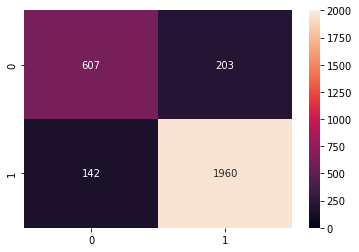

In [54]:
res = confusion_matrix(target_test, clf.predict(scaled_test))
sns.heatmap(res,annot=True,fmt='.0f',vmin=0,vmax=2000)

# Feature importance

## Tree based estimators

In [22]:
model = clf.best_estimator_

In [23]:
model.feature_importances_.shape

(74,)

In [ ]:
[selected_feats[idx] for idx in np.argsort(model.feature_importances_)[::-1]]